In [115]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
from pandas import pivot_table
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, make_scorer
import seaborn as sns

In [116]:
#In Python: Define a database name, and your username for your computer (CHANGE IT BELOW). 
dbname = 'wespire_app_data'
username = 'xixibest'

## 'engine' is a connection to a database
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

In [117]:
#Get the type of each action in March and April 2017 completed by the user.
sql_query = """
SELECT scores.id, points,
  scores.user_id,
  scores.scorable_id,
  scores.created_at,
  categories.name_reporting
FROM scores
LEFT JOIN classifications ON classifications.categorizable_type = 'Act'
AND classifications.categorizable_id = scores.scorable_id
LEFT JOIN categories ON categories.id = classifications.category_id
WHERE scorable_type = 'Act' AND scores.created_at >= '2017-03-01' AND scores.created_at <= '2017-04-30'
"""
user_Act = pd.read_sql_query(sql_query,con)
#Data aggregation: get the number of actions on each type for each user.
user_Act['dummy']=1
user_Act.name_reporting[pd.isnull(user_Act['name_reporting'])]='None'
table = pivot_table(user_Act, values='dummy', index=['user_id'],
                   columns=['name_reporting'], aggfunc=np.sum, margins=True)
table.fillna(value=0,inplace=True)
table=pd.DataFrame(table)
table['user_id'] = table.index
table.sort_values(by='user_id').head()
table.head()

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


name_reporting,Enjoy,Food,Giving,HR,Health & Wellness,Home Improvement,How to use WeSpire,Learn,None,Office,Recycle,Reduce,Reuse,Social,Society,Sustainable Consumption,Transportation,Volunteering,All,user_id
user_id,,,,,,,,,,,,,,,,,,,,
144,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0,144
6148,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,3.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,23.0,6148
6171,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,6171
6172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6172
19846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,19846


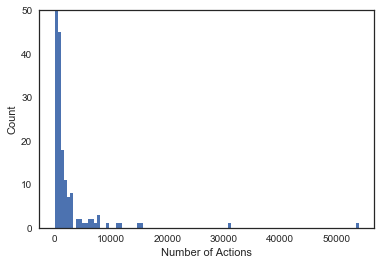

In [118]:
#Get the total actions completed by each user.
sql_query = """
SELECT user_id, count(*) FROM scores
WHERE scorable_type = 'Act'
AND scores.created_at >= '2017-03-01' AND scores.created_at <= '2017-04-30'
GROUP BY user_id
"""
user_TotalAct = pd.read_sql_query(sql_query,con)
user_TotalAct.rename(index=str, columns={"user_id": "user_id", "count": "num_of_acts"},inplace=True)
ax = user_TotalAct.num_of_acts.hist(bins=100)
ax.set_ylim(0,50)
ax.set_xlabel('Number of Actions')
ax.set_ylabel('Count')
ax.grid(False)
# for actions>3000, it is a bad user.
baduser = user_TotalAct[user_TotalAct.num_of_acts >=3000]

In [119]:
#Get the user who has at least one more visit before March 2017.
first_visit_today = pd.read_csv('first_visit_today.csv', low_memory=False)
first_visit_today=pd.DataFrame(first_visit_today)
#first_visit_today_1 the users who have logged in in March and April 2017.
first_visit_today_1 = first_visit_today[(first_visit_today.timestamp >='2017-03-01') & 
                                          (first_visit_today.timestamp <= '2017-04-30')]
# Find out the users with at least one visit before Feb, 2017
OneVisit_befFeb = first_visit_today[first_visit_today.timestamp < '2017-02-28']
visit = first_visit_today_1[first_visit_today_1.user_id.isin(OneVisit_befFeb.user_id)]
visit.head()

,id,received_at,uuid,avatar,brand,brand_base_url,brand_logo,brand_program_name,campaign,context_group_id,...,team_2,team_2_id,team_3,team_3_id,team_4,team_4_id,team_5,team_5_id,team_6,team_6_id
116453,a51e1ed0-b155-4c5d-8cf8-41e78ff40dca,2017-03-01 00:00:24.407,174883,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM,https://greenadvantage.wespire.com,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM Resorts My Green Advantage,NaN,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116454,7074140a-9fc3-49d0-af47-a81870d68d9d,2017-03-01 00:00:56.787,174931,https://res.cloudinary.com/hyetmyubn/image/upl...,Timberland,https://makeitbetter.wespire.com,https://res.cloudinary.com/hyetmyubn/image/upl...,Make It Better,NaN,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116455,bfc5ff67-831c-4432-857d-2a65c96576c3,2017-03-01 00:10:18.653,174901,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM,https://greenadvantage.wespire.com,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM Resorts My Green Advantage,NaN,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116456,fc965a8b-83ef-4f33-a4e4-c6dcb999b1d8,2017-03-01 00:27:59.835,174927,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM,https://greenadvantage.wespire.com,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM Resorts My Green Advantage,NaN,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116457,0513812a-151f-4042-aed8-c25002173301,2017-03-01 00:33:17.381,174929,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM,https://greenadvantage.wespire.com,https://res.cloudinary.com/hyetmyubn/image/upl...,MGM Resorts My Green Advantage,NaN,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
#user_login is the number of visits for each user.
user_login = visit.groupby(visit['user_id'])['timestamp'].nunique()
user_login = pd.DataFrame(user_login)
user_login.columns = ['num_of_login']
user_login['user_id']=user_login.index
user_login.head()

,num_of_login,user_id
user_id,,
144,21,144
6148,17,6148
6172,2,6172
16393,1,16393
19681,9,19681


In [121]:
#Merge user_login with table to get user's action type.
user = pd.DataFrame()
user = user_login.merge(table, how = 'left', on = 'user_id')
user.fillna(0,inplace=True)
#Remove the bad users.
user_good = user[~(user.user_id.isin(baduser.user_id))]
#Remove the users whose actions do not go into categories.
user_good_2 = user_good[~(user_good.All==0)]
user_good_2.head()

,num_of_login,user_id,Enjoy,Food,Giving,HR,Health & Wellness,Home Improvement,How to use WeSpire,Learn,...,Office,Recycle,Reduce,Reuse,Social,Society,Sustainable Consumption,Transportation,Volunteering,All
0,21,144,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0
1,17,6148,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,...,3.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,23.0
2,2,6172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
5,12,19846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
6,20,23180,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0


In [122]:
user_good_2['num_of_login'].quantile([0.5,0.75,0.85])

0.50    3.0
0.75    6.0
0.85    9.0
Name: num_of_login, dtype: float64

In [123]:
#Define active = 1 if num_of_login is larger than 9, the 0.85 quantile.
user_good_2['Engagement']=np.where(user_good_2.num_of_login >=9, 1, 0)

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


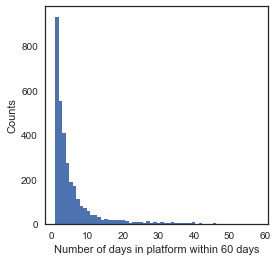

In [124]:
ax = user_good_2.num_of_login.hist(bins=max(user_good_2.num_of_login),figsize=(4,4))
ax.set_xlabel('Number of days in platform within 60 days')
ax.set_ylabel('Counts')
ax.grid(False)

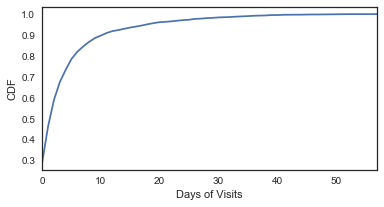

In [125]:
values, base = np.histogram(user_good_2.num_of_login,bins=user_good_2.num_of_login.max())
#evaluate the cumulative
cumulative = np.cumsum(values)
cumulative_norm = cumulative*1.0/cumulative[-1]
# plot the cumulative function
#plt.plot(base[:-1], cumulative, c='blue')
#plt.xlable 
#plt.show()

cumulative_norm=pd.DataFrame(cumulative_norm)
ax = cumulative_norm.plot(use_index=True,figsize=(6,3))

ax.set_xlabel('Days of Visits')
ax.set_ylabel('CDF')
ax.legend_.remove()
ax.grid(False)

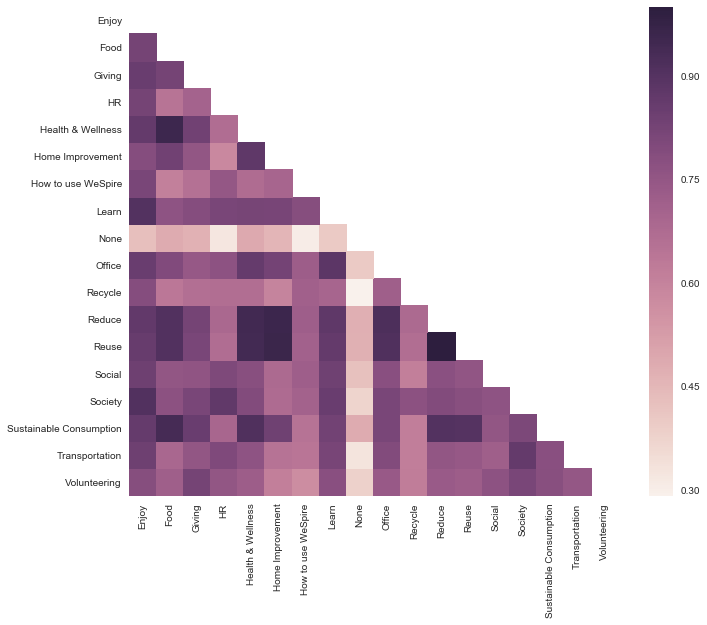

In [126]:
# get X and y from table
X, y = user_good_2.ix[:,'Enjoy':'Volunteering'], user_good_2.ix[:,'Engagement']

y=pd.DataFrame(y, columns = ['Engagement'])

corr = X.corr()

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
#            square=True, xticklabels=5, yticklabels=5,
#            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
sns.heatmap(corr, mask=mask, vmax=1.0, square=True)

In [127]:
s = corr.unstack()
so = s.order(kind="quicksort")
#len(s)
so[len(so)-23:len(so)-10]
#so = s.order(kind="quicksort")

/Users/xixibest/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


Home Improvement         Reduce                     0.960183
Reuse                    Home Improvement           0.965938
Home Improvement         Reuse                      0.965938
Reduce                   Reuse                      0.998055
Reuse                    Reduce                     0.998055
Enjoy                    Enjoy                      1.000000
Sustainable Consumption  Sustainable Consumption    1.000000
Food                     Food                       1.000000
Giving                   Giving                     1.000000
HR                       HR                         1.000000
Health & Wellness        Health & Wellness          1.000000
Home Improvement         Home Improvement           1.000000
How to use WeSpire       How to use WeSpire         1.000000
dtype: float64

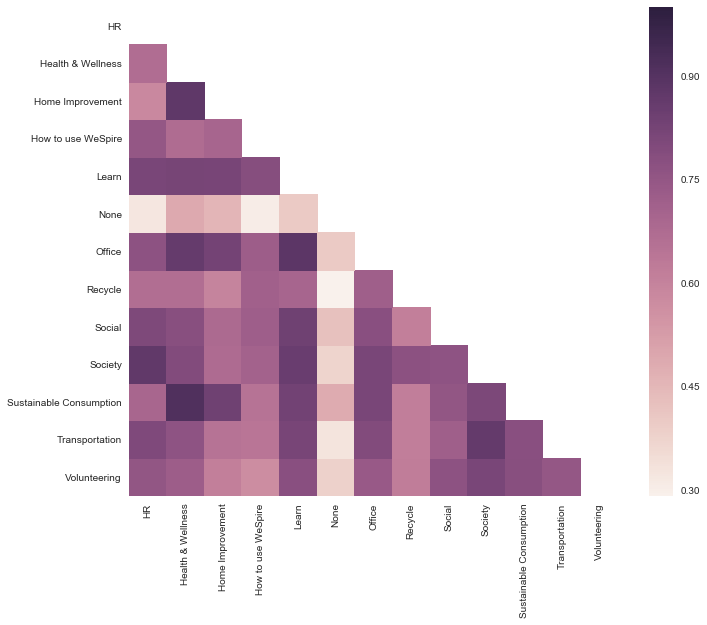

In [128]:
#Remove the highly correlated ones
user_good_decorr = user_good_2.drop(['Food', 'Reduce','Reuse','Enjoy','Giving'], axis=1)

X_decorr, y = user_good_decorr.ix[:,'HR':'Volunteering'], user_good_decorr.ix[:,'Engagement']
corr = X_decorr.corr()

# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
#            square=True, xticklabels=5, yticklabels=5,
#            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
sns.heatmap(corr, mask=mask, vmax=1.0, square=True)

In [129]:
# Over sampling Engagement = 1 data
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler

Over = RandomOverSampler(random_state=50, ratio = 'auto')
X_res, y_res= Over.fit_sample(X_decorr, y)
X_res = pd.DataFrame(X_res)
X_res.columns = list(X_decorr)

y_res = pd.DataFrame(y_res)

In [130]:
#Run Logistic Regression on the balanced data
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=14)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20,random_state=15)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 1945 to 3829
Data columns (total 13 columns):
HR                         4339 non-null float64
Health & Wellness          4339 non-null float64
Home Improvement           4339 non-null float64
How to use WeSpire         4339 non-null float64
Learn                      4339 non-null float64
None                       4339 non-null float64
Office                     4339 non-null float64
Recycle                    4339 non-null float64
Social                     4339 non-null float64
Society                    4339 non-null float64
Sustainable Consumption    4339 non-null float64
Transportation             4339 non-null float64
Volunteering               4339 non-null float64
dtypes: float64(13)
memory usage: 474.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 3718 to 4937
Data columns (total 1 columns):
0    1085 non-null int64
dtypes: int64(1)
memory usage: 17.0 KB


In [131]:
def roc_auc_score_proba(yy_true, pproba):
    return roc_auc_score(yy_true, pproba[:, 1])
auc_define = make_scorer(roc_auc_score_proba, needs_proba=True)

In [ ]:
log_CV = LogisticRegressionCV(class_weight='balanced', cv=10, Cs = 100, 
                              penalty='l2', scoring=None, solver='lbfgs', refit = True,
                              dual=False)
logCV = log_CV.fit(X_train,y_train)

y_pred_logCV_prob = logCV.predict_proba(X_test)

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_logCV_prob[:,1])
roc_auc= auc(fpr, tpr)
roc_auc
plt.plot(fpr, tpr, label ='ROC curve (area = %f)'%roc_auc)
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.legend(loc="lower right")
plt.axis('scaled')

In [103]:
np.where(np.around(tpr, 2)==0.6)

(array([180, 181, 182, 183, 184, 185, 186, 187]),)

In [104]:
threshold[180]

0.43837573121959555

In [105]:
y_pred_logCV = np.where(y_pred_logCV_prob[:,1] > 0.44, 1, 0)

In [106]:
logCV.C_

array([ 0.14174742])

In [107]:
metrics.confusion_matrix(y_test, y_pred_logCV)

array([[459,  88],
       [218, 320]])

In [108]:
metrics.accuracy_score(y_test, y_pred_logCV)

0.71797235023041472

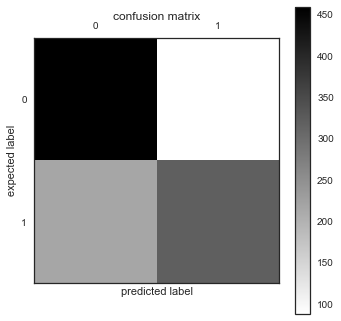

In [109]:
plt.matshow(metrics.confusion_matrix(y_test, y_pred_logCV), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [110]:
metrics.precision_score(y_test, y_pred_logCV)

0.78431372549019607

In [111]:
metrics.recall_score(y_test, y_pred_logCV)

0.59479553903345728

In [112]:
metrics.f1_score(y_test, y_pred_logCV)

0.67653276955602537

In [113]:
coef = (logCV.coef_).transpose()
#coef = (logCV.coef_* DataRange).transpose()
coef = pd.DataFrame(coef)
coef.columns = ['Feature_Coefficient']
coef['Feature'] = list(X_train)
coef = coef.sort_values(by='Feature_Coefficient')
coef.set_index('Feature',inplace=True,drop=False)
coef

,Feature_Coefficient,Feature
Feature,,
Transportation,-0.294248,Transportation
HR,-0.233043,HR
Society,-0.161561,Society
Sustainable Consumption,-0.072950,Sustainable Consumption
Learn,-0.052527,Learn
Recycle,-0.036811,Recycle
Office,-0.018824,Office
Home Improvement,0.001997,Home Improvement
None,0.007559,None


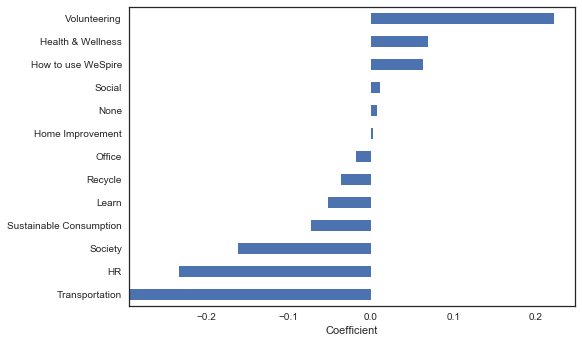

In [114]:
ax = coef.plot(kind='barh',use_index=True)
ax.set_yticklabels(coef.Feature)
ax.legend(['coefficient'])
ax.legend_.remove()
ax.set_xlabel('Coefficient')
ax.set_ylabel('')
#ax.set_xlim(-0.01,0.5)